# -- ARTS multi-FOV 2DVAR surface retrievals --

In [1]:
#  David Duncan, Chalmers University, Feb 2019

#  this script uses ARTS OEM to experiment with retrieval of a synthetic scene. 
#    the goal here is to probe the spatial resolution of geophysical parameter 
#    that may be retrievable with such a sensor, focused on AMSR2 and surface params

# this setup, in steps/words:
### - define an antenna response that is frequency dependent, gaussian, symmetric
### - define sensor position and line of sight for each scan at middle of scan
### - define an angular grid (zenith & azimuth) for each scan that encompasses npix
### - sensor angles are all 'absolute' whereas the angular grid and antenna response 
###    are all relative to the central bore sight of the scan
### - a lat/lon grid is also defined that must encompass all observation points simulated
### - the same angular grid and simulation setup is assumed/copied for all nscans, and 
###    mblock_dlos_grid allows all simulations to be run at the same time

### *** this setup outputs simulates TBs for chosen channels of AMSR2
###    with antenna patterns taken into account and decoupled from any retrieval grid, with
###    pencil beam calculations sampling the antenna pattern according to the angular grid
###    defined

### a priori covariances are defined in terms of standard deviations and decorrelation lengths
###  and observation error covariances are frequency dependent

# updated/revisited early April to finalize synthetic setup for the manuscript, update plotting
#  calls to match real scenes retrieval code output

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm as cmo
from h5py import File
from netCDF4 import Dataset
import time
startt = time.time()

from matplotlib.patches import Ellipse
from matplotlib import ticker
from cartopy import crs as ccrs
from cmocean import cm as cmo

# Define # of vars, channels, size of retrieval, and covariance assumptions

In [3]:

# frequency subset, defined by AMSR2 frequency indices: 0=6.9GHz, 1=7.3, 2=10.6, 3=18.7, 4=23.8, 5=36.5, 6=89
fsub  = np.array([0, 1, 2, 3, 5, 6]) # choose which frequencies to run (runs both polarisations--v/h)
sfsub= str("frs")+"".join(map(str,fsub)) #  string of frequencies (for plot outputs)

# if decorrelations lengths less than .1 -> diagonal Sx matrix
deco_sst = 1.5  # SST decorrelation length of a priori [deg] -- set to near-zero if wanting none
deco_wsp = 1.5  # wind decorrelation length of a priori [deg] 
sv = True      # whether or not to save output plots

nrvar    =   2   # number of retrieval variables, 1 will be SST only, 2 for SST+windspeed

angfac   =   7   # angular samples per degree or between pix (good value depends on freqs used)
sx_sst   = 1.0   # a priori std deviation for SST
sx_wsp   = 1.0   # a priori std deviation for wind speed (if nrvar > 1)
#xcorr    = 0.0   # cross correlation between SST and wind speed -- not currently used (sparse matrix faster)
#  note: for speed, the angular grid is the biggest limiting factor, so if using low frequencies only

npix     =  15   # pixels across each scan considered
nscans   =  11   # consecutive scans considered

# these should likely remain fixed:
noise_fac = 1.0  # multiply sense noise (nedt) by this factor
nedt = np.array([0.34, 0.43, 0.7, 0.7, 0.6, 0.7, 1.2])[fsub] # from published NEdT values
npol     =  2    # number of polarizations considered (2=V/H both, 1=intensity only)

# retrieval grid resolution (set down below)
r_resa, r_reso = 0.08, 0.08
uty,    utx    = 0.8,  0.8      # grid defined radially out from center, so these are half-widths

# plot version (end of plot filenames):    ## assumes decorrelation, prior, rgrid dimensions are same for both
pv = 'syn1_ap'+str(round(sx_sst*10))+'-'+str(round(deco_sst*10))+'d_'+\
    'r'+str(round(100*r_reso))+'-'+str(angfac)+'a_'+str(round(noise_fac))+'n_'+sfsub      
print(pv)

syn1_ap10-15d_r4-7a_1n_frs012356


In [4]:
# Define lat/lon grid that observation points and angular grid lie within
lat0     = 0.0  # center of grid in lat, lon 
lon0     = 0.0
nlat, nlon =  30, 30 #100        # number of lat and lon divisions
latwid, lonwid = 1.5, 1.5    # actual grid widths are double these

resa = 2*latwid/nlat  #lat grid resolution
reso = 2*lonwid/nlon  #lon grid resolution
print('Grid resolution is ', resa, reso)
print('Retr grid resolution is ', r_resa, r_reso)
 
la_grid = lat0 + np.arange(-latwid, latwid+resa, resa)
lo_grid = lon0 + np.arange(-lonwid, lonwid+reso, reso)
# keep these (non-ARTS vars) for sake of plotting at the end!
 
#print('corners of la_grid: ',la_grid)
#print('midpoints of la_grid (ARTS ws grid): ',latgrid[0:nlat]+np.diff(la_grid)*.5)

Grid resolution is  0.1 0.1
Retr grid resolution is  0.04 0.04


# Set up ARTS environment

In [5]:
%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/ 
#%env OMP_NUM_THREADS=1 # to limit computation to single core or set # of cores, set the above ARTS API keyword

%matplotlib inline
from scipy.spatial.distance import pdist      # calculate pair-wise distances (euclidean)
from scipy.spatial.distance import squareform # convert from reduced matrix to square

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity=0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

from typhon.arts.workspace.variables import *

# set various ARTS agendas:
ws.Copy( ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )
@arts_agenda
def geo_pos_agendaPY(ws):
    ws.geo_posEndOfPpath()
ws.Copy( ws.geo_pos_agenda, geo_pos_agendaPY)  ## new one, set by patrick in his cfile

# define absorbing species and sensor (here using metmm library, used again below)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])#,"liquidcloud-ELL07"])
ws.abs_lines_per_speciesSetEmpty()

ws.stokes_dim = npol     # to get V and H pol set to 2
ws.iy_unit = "PlanckBT"  # equivalent: ws.StringSet( iy_unit, "PlanckBT" )

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


In [6]:
# set up atmosphere and surface variables:
ws.atmosphere_dim = 3  # 3D atmosphere
p = np.array([1015.,950.,800., 600.,300.])*100.0 #keep it simple, otherwise slower fwd model 
#p = np.array([1015.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = p[:] 
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
ws.AtmosphereSet3D()

ws.lat_grid = np.copy( la_grid[0:nlat] + np.diff(la_grid)*.5 ) # to avoid mismatch between ARTS and pcolormesh
ws.lon_grid = np.copy( lo_grid[0:nlon] + np.diff(lo_grid)*.5 ) #  i.e. getting lat/lon midpoints of boxes

ws.AtmFieldsCalcExpand1D()  # set to given p_grid or z_grid
#ws.vmr_field.value[0,:,:,:] *= 0.50 # if wanting to scale water vapour

# if using coarse atmosphere but wanting accurate ray tracing:
ws.ppath_lmax = 350.0  # set maximum distance between points when computing absorption along path [m]

# Define synthetic ocean surface scene, set in ARTS

s_data shape:  (4, 30, 30)


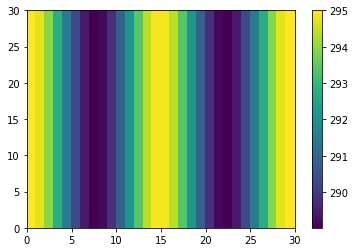

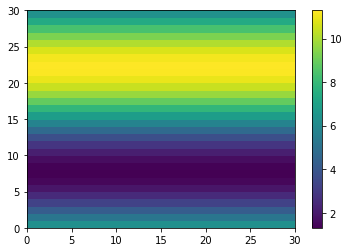

In [7]:
# Surface properties -- define ocean surface for simulations

nala, nalo = np.size(ws.lat_grid.value), np.size(ws.lon_grid.value) # size of ARTS lat/lon grid
s_names = ["Water skin temperature","Wind speed","Wind direction","Salinity"]
s_data = np.zeros([len(s_names), nala, nalo])  ## page/row/col
print('s_data shape: ',s_data.shape)

tback                   = 292.0 # sst background
wsp                     = 6.3   # 10m wind speed
s_data[0,:,:] = tback
s_data[0,:,:] += 3.0 * np.cos( np.tile(np.linspace(-2*np.pi,2*np.pi,nalo),[nala,1])) #.transpose() 
s_data[1,:,:] = wsp
#s_data[1,:,:] += np.random.normal(1.2, 1.9, [nala,nalo])
#s_data[1,:,:] += 0.35 * np.tile(np.arange(0,nala),[nalo,1]).transpose() 
s_data[1,:,:] += 5.0 * np.sin( np.tile(np.linspace(-np.pi,np.pi,nala),[nalo,1])).transpose() 
s_data[2,:,:] = 90 # token wind direction value
s_data[3,:,:] = 0.034 # token salinity value

# write these to ARTS variables 
ws.Copy(ws.surface_props_names, s_names)
ws.Copy(ws.surface_props_data, s_data)
ws.MatrixSetConstant(ws.z_surface, nala, nalo, 0.0) # explicitly set the surface to 0m altitude

plt.pcolor(s_data[0,:,:]) # quick look for SST
plt.colorbar()
plt.show()
plt.pcolor(s_data[1,:,:]) # quick look for wsp
plt.colorbar()
plt.show()

# Define antenna pattern

In [8]:
# Set and calculate some basic variables for antenna and scanning

### All will be replaced or superseded if using L1R data as input
 
zsat   = 699.7e3      # Satellite altitude [m] -- can read this in later
vsat   = 6.76e3       # Satellite velocity [m/s]
dt     = 2.6e-3       # Integration time [s] -- 2.6ms for low freqs, 1.3ms for 89GHz
rpm    = 40           # Rotations per minute -- same for AMSR-E and AMSR2
 
# nautical mile constant?  1852m = 1nmi
m2deg  = 1/(60*1852)                          # Conversion from m to latitude
dang   = dt * 360 * rpm / 60                  # Angular distance between samples
dlat   = m2deg * vsat * 60 / rpm              # Latitude distance between scans
print(dang,dlat)

0.624 0.09125269978401726


In [9]:
# channel HPBW sizes in km, from amsr2 documentation
widths  = np.array([35., 35., 24., 14., 15.,  7., 3.])[fsub] # in km across
heights = np.array([62., 62., 42., 22., 26., 12., 5.])[fsub] #  per freq, 6/7/10/18/23/36/89

width  = 1.8           # Max half-width of antenna simulated (if HPBW is 1.8deg, width=2 covers 2x the HPBW)
resol  = 0.01          # angular resolution (same in zenith/azimuth)
# note: for a given angular resolution (might vary), width=2 yields 99.96% of total power @6GHz 
#   compared to width=20 and 99.99999% @10GHz, width=1.5 yields 99.0 and 99.994 @ 6,10
#resol, width = dang/(angfac*5), awidth # set here instead of calling func
print('angular resolution of response grid [deg]: ',resol)

adata = [[ 6.925e9 ,  1.80],   # AMSR2 center frequency and beamwidth (deg)
         [ 7.300e9 ,  1.80],   # assumed the same for V/H polarizations
         [ 10.65e9 ,  1.20],
         [ 18.70e9 ,  0.65],
         [ 23.80e9 ,  0.75],
         [ 36.50e9 ,  0.35],
         [ 89.00e9 ,  0.15]] 

adata = np.array(adata, order="C").transpose()[:,fsub] # choose selected frequencies (set above)

# define zenith, azimuth grid on the ground (relative to bore sight) -- assumed to be square, 2xWidth wide
x  = np.arange( -width, width+resol, resol )  #this gives angular antenna response points in za,aa
x2 = x**2   # since assumed origin is 0, do squaring here 
nf, nx = len(adata[0,:]), np.size(x)   # num frequencies, size of antenna grid

csub = np.sort(np.append(fsub*2,fsub*2+1))
ch_str = np.array(['6V','6H','7V','7H','10V','10H','18V','18H',
                   '23V','23H','36V','36H','89V','89H'])[csub] 
#print(ch_str)

from typhon.arts.griddedfield import GriddedField4
gf4 = GriddedField4()   # ARTS variable type, found in typhon
gf4.name = 'AMSR2 antenna response'
gf4.gridnames =  [ 'Polarisation', 'Frequency', 'Zenith angle', 'Azimuth angle' ]
###  note: za & aa are equally spaced, and we're treating V/H as having identical responses
if npol==2: gsp="1" 
else: gsp="0"
gf4.grids     = [ [gsp], adata[0,:], x, x ]
gf4.dataname  = 'Response'
gf4.data      = np.zeros([ 1, nf, nx, nx ], order="C")
print('size of antenna_reponse grid: ',gf4.data.shape)

for i in range(nf):
    si = adata[1,i] / (2*np.sqrt(2*np.log(2)))  # calculate standard deviation first, based on HPBW
    gf4.data[0,i,:,:] = np.exp( - np.tile(x2,[nx,1])/si**2 - np.tile(x2,[nx,1]).transpose()/ si**2 )

# frequency grid of simulation is defined according to sensor setup above 
ws.f_grid.value = np.copy(gf4.grids[1])  # array with each frequency (not channel)


angular resolution of response grid [deg]:  0.01
size of antenna_reponse grid:  (1, 6, 361, 361)


# Define bore sights for one scan, angular grid for fwd model

In [10]:
# Determine bore-sight angles to use for one scan 
 
# psteps defines the pixels across one scan
psteps   = np.arange(-(npix-1)/2, (npix-1)/2 +1, 1)  #  if npix is odd then middle boresight is in the middle
# ssteps defines position of spacecraft for each scan, evenly distributed around the middle scan
ssteps   = np.arange(-(nscans-1)/2, (nscans-1)/2 +1, 1) 

#  center line of sight... defined as AMSR2 EIA and 0 azimuth angle
los0    = [ 180-47.5, 0 ]  # 47.5 is off-nadir angle of AMSR2, 180 for looking straight down

# bsights defines the bore sight zenith and azimuth angles across the scan 
##-- just for one scan, assumed to be same / repeated for all scans
bsights = np.array([ np.repeat(los0[0],npix), los0[1]+dang*psteps ]).transpose()  # size: [npix,2]
print('bsights:',(bsights[:,1]))

bsights: [-4.368 -3.744 -3.12  -2.496 -1.872 -1.248 -0.624  0.     0.624  1.248
  1.872  2.496  3.12   3.744  4.368]


In [11]:
# Define angular grid for pencilbeam calculations

# can use 'dang' or not, but benefit of using it is having RT calc at each boresight (i.e. antenna beam max)
#  in azimuth direction. if using 'dang' for zenith too then it's an evenly spaced angular grid.

n = np.floor( width * angfac )  # angular width * angular samples per deg
za_grid = np.array( los0[0] +  np.arange(-n,n+1)/angfac)  ## effectively taking 'width' on either side of 0
#n = np.floor( angfac * width / dang )  # number per degree * angular width / distance between boresights
#za_grid = np.array( los0[0] + (dang/angfac) * np.arange(-n,n+1))  # zenith angle grid

en = np.floor( angfac * ( bsights[-1,1] + width ) / dang ) # azimuth of boresight at edge +width
aa_grid = np.array( los0[1] + (dang/angfac) * np.arange(-en,en+1))  # azimuth angle grid
#en = np.floor((bsights[-1,1]+width)*angfac) ## yields az from boresight at edge plus 'width' (could prob do width/2)
#aa_grid = np.array( los0[1] + np.arange(-en,en+1/angfac)/angfac)  # azimuth angle grid

#print('zenith grid: ',za_grid) 
#print('azimuth grid: ',aa_grid) 
print('zenith grid spacing: ',np.diff(za_grid[:2]))
print('azimuth grid spacing: ',np.diff(aa_grid[:2]))

zenith grid spacing:  [0.14285714]
azimuth grid spacing:  [0.08914286]


In [12]:
# Set sensor_pos (position), sensor_los (line of sight) for ARTS

ws.sensor_los = np.tile(los0, [nscans,1])  # sensor line of sight for each scan

shift   = 7.4   # Latitude shift to centre calculations around lat0

# sensor_pos should be columns of altitude, SClat, SClon  ###  
#   with real data these come from L1R files and transform X/Y/Z to lat/lon
#   currently one alt/sclat/sclon for each scan (i.e. each of nscans)

ws.sensor_pos = np.hstack([np.repeat(zsat, nscans).reshape(nscans,1),
                          np.array(lat0 - shift + dlat * ssteps).reshape(nscans,1), 
                          np.repeat(lon0, nscans).reshape(nscans,1)])

#print(ws.sensor_pos.value)
#print(np.shape(ws.sensor_pos.value))  # should be alt, SClat, SClon for each of nscans

In [13]:
# turn off jacobian calc for primary yCalc, keep clear-sky (non-scattering) setup
ws.jacobianOff()
ws.cloudboxOff()

# Set the surface agenda for ARTS

In [14]:
# define surface agenda (need transmittance to run FASTEM):
varnam = ["Optical depth"]
ws.Copy(ws.iy_aux_vars, varnam)
ws.VectorCreate( "transmittance" )
#ws.transmittance = np.ones( ws.f_grid.value.shape ) * 0.0  #  FOR TESTING ONLY!!!!!

@arts_agenda
def iy_surface_agendaPY(ws):
    ws.specular_losCalc()
    # if wanting to test transmittance values, comment out next 3 calls and set outside agenda...
    #  if ppathCalc is called and uses assumed inputs there are problems, so specify all!
    ws.ppathCalc(ws.ppath_agenda, ws.ppath_lmax, 
       ws.ppath_lraytrace, ws.atmgeom_checked, ws.t_field, ws.z_field, 
       ws.vmr_field, ws.f_grid, ws.cloudbox_on, ws.cloudbox_checked, 
       ws.ppath_inside_cloudbox_do, ws.rtp_pos, ws.specular_los, ws.rte_pos2 )
    ws.iyEmissionStandard()
    ws.transmittanceFromIy_aux(transmittance=ws.transmittance)
    ws.SurfaceFastem( transmittance = ws.transmittance, fastem_version=6 ) 
    ws.iySurfaceRtpropCalc()
    
ws.Copy(ws.iy_surface_agenda, iy_surface_agendaPY) # copy python-defined agenda to ARTS

# Perform checks and set up mblock grid

In [15]:
# perform some checks:
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()

In [16]:
# create vector mblock_reference_los and matrix mblock_target_los (to be used by DiffZaAa)
mblock_reference_los = np.array(los0)

# want to have all individual angle pairs distinct... so repeat one serially and one n times
mblock_target_los = np.array(np.transpose( np.stack( 
                    [ np.repeat(za_grid, aa_grid.size) , 
                      np.tile(  aa_grid, za_grid.size) ]) ) , order = "C")
## need to specify 'C' order or else stride is wrong and array values are read wrong by ARTS!

# take the differences of zenith and azimuth angles to convert to chosen angle space
ws.DiffZaAa(ws.mblock_dlos_grid, mblock_reference_los, mblock_target_los)

In [17]:
### Calculate the sensor response function from the antenna response
ws.VectorCreate("antenna_reference_los")
ws.MatrixCreate("antenna_target_los")
ws.antenna_reference_los = np.array(los0)
ws.antenna_target_los = np.array(bsights, order="C")
ws.DiffZaAa(ws.antenna_dlos, ws.antenna_reference_los, ws.antenna_target_los)

# define sensor... done above, but apply gf4 typhon/arts object to antenna_response:
ws.sensor_norm = 1
ws.antenna_dim = 2
ws.antenna_response = gf4 

ws.sensor_responseInit()

## flipping from first two stokes components (I/Q) to V/H-pol Tb here... 
ws.instrument_pol = [5,6] # indices for V,H (1,2 are I,Q)

ws.sensor_responsePolarisation()
ws.sensor_responseAntenna()
ws.sensor_checkedCalc()


# Initiate the retrieval setup

In [18]:
# first, set up the retrieval grid, which is independent from fwd model and
#  independent from the background (lat/lon/alt) grid if chosen

r_lims = [lat0-uty, lat0+uty, lon0-utx, lon0+utx] # lat/lon limits  (box in middle of overall box)

r_lon  = np.arange(r_lims[2], r_lims[3]+r_reso, r_reso)
r_lat  = np.arange(r_lims[0], r_lims[1]+r_resa, r_resa)

# create grids of retrieval lats/lons for calculations of distance and plotting below
ri, rj = np.meshgrid(r_lat, r_lon, indexing='ij')  
print(ri.shape,rj.shape)
# and the same for original ARTS background grid
gi, gj = np.meshgrid(ws.lat_grid, ws.lon_grid, indexing='ij')
print(gi.shape,gj.shape)

# calculate 'x_back' (or background), which is mapping s_data to the retrieval grid
x_back = np.zeros([nrvar, r_lat.size, r_lon.size])
print('rgrid dimensions: ',x_back.shape)
from scipy.interpolate import interp2d 
f = interp2d(ws.lon_grid, ws.lat_grid, s_data[0,:,:]) #, kind='cubic')
x_back[0,:,:] = f(r_lon,r_lat)
if nrvar>1:
    f = interp2d(ws.lon_grid, ws.lat_grid, s_data[1,:,:]) #, kind='cubic')
    x_back[1,:,:] = f(r_lon,r_lat)

#for r in range(nrvar):
#    plt.matshow(x_back[r,:,:], cmap=cmo.dense)
#    plt.colorbar()
#    plt.matshow(s_data[r,:,:], cmap=cmo.dense)
#    plt.colorbar()


(41, 41) (41, 41)
(30, 30) (30, 30)
rgrid dimensions:  (2, 41, 41)


# Set prior and covariance matrices

In [19]:
# define Xa (formally set in ARTS below)
xa = np.zeros([nrvar, r_lat.size, r_lon.size]) # a priori matrix, should be similar to s_data
print('Xa shape: ', xa.shape)
xa[0,:,:] = np.mean(x_back[0,:,:]) # set constant
if nrvar>1:
    xa[1,:,:] = np.mean(x_back[1,:,:])

# then observation errors (uncorrelated sensor noise)
se_cov = np.diag(np.tile(np.repeat((noise_fac*nedt)**2,2), npix*nscans )) 
print('Se cov shape: ', se_cov.shape) # square matrix of side length npix*nscans*nf*2

# calculate distances between points on retrieval grid for distance-dependent correlations in sx_cov
#   "Convert a vector-form distance vector to a square-form distance matrix", from point-wise distances
#    from scipy pdist function:
dists = squareform( pdist( np.array([ri.flatten(order="F"), rj.flatten(order="F")]).transpose() )) 
# ri/rj flattened in F order because all 2D arrays interpreted in 1D by arts get reshaped internally!

# can try making decorrelation lengths gradient-dependent (wait for a non-flat prior for testing!):
#rygrad, rxgrad = np.gradient(xa[:,:,0])
#pseudo_grad = 0.5 * (np.abs(rygrad)*r_resa + np.abs(rxgrad)*r_reso)   # should be array of xa size
## abs values, add gradients in x and y by retr grid resolution
#deco_grid = np.ones_like(dists)*deco
#deco_grid[pseudo_grad > 0] *= np.exp(-1.0*pseudo_grad[pseudo_grad>0])  
## ad hoc, weight decorr length to be shorter if there's a non-zero gradient in apriori 

# then a priori state errors (Sa or Sx)
len_rgrid = r_lat.size*r_lon.size # total number of points in retrieval grid
nsx = np.sum(range(nrvar+1)) # 'triangle number' determines # of matrix blocks that define sx_cov

# blocks of larger, sparse Sa unless the off-off diagonal elements are filled in (SST/wsp covariances)
sx_cov = np.zeros([len_rgrid,len_rgrid, nsx], order="C")

# common for both:
sx_cov[:,:,0] = np.diag( np.tile(sx_sst**2, len_rgrid)) 
corrs_sst = np.exp(-dists/deco_sst) 
sx_cov[:,:,0]  = sx_sst * sx_sst * corrs_sst[:,:]  # FOR NON-LOC-DEP SX_SST    i.e.  cov = r * sig * sig
    
if nrvar==2:  # wind and cross-correlations
    corrs_wsp = np.exp(-dists/deco_wsp)
    sx_cov[:,:,1] = np.diag( np.tile(sx_wsp**2, len_rgrid)) 
    sx_cov[:,:,1] = sx_wsp * sx_wsp * corrs_wsp[:,:]  # if sx_wsp is NOT function of loc, calc here
    #sx_cov[:,:,2] = sx_wsp * sx_sst * corrs_wsp[:,:] * xcorr  # cross correlations -- again, NOT f(loc)

#for rv in range(nsx):   # can plot each a priori covariance matrix block:
#    plt.matshow(sx_cov[:,:,rv])
#    plt.colorbar()
#    plt.show()
#

Xa shape:  (2, 41, 41)
Se cov shape:  (1980, 1980)


# Finalize retrieval setup in ARTS, run yCalc for syn. observation vector

In [20]:
# first forward model call, to calculate synthetic observation vector
print('running yCalc')
ws.yCalc() 
print('done initial yCalc')
initial_tb = np.copy(ws.y.value)  # copy into python memory
#print(np.shape(initial_tb))


# define first guess for x in iteration. if no ws.x is set before OEM runs, it uses ws.xa.
#### flatten x_back / xa / whatever in correct order for ARTS
firstg = np.concatenate([bla.flatten(order = "f") for bla in xa])
ws.x = firstg
#ws.x = ws.xa #firstg


running yCalc
done initial yCalc


In [21]:
# formally set covarainces and prior for ARTS OEM:
#  [use numpy copy to make damn sure arrays are separate in memory]

ws.retrievalDefInit()  # initialize then add variables

for r in range(nrvar):
    ws.retrievalAddSurfaceQuantity( g1=r_lat, g2=r_lon, quantity=s_names[r])
    ws.covmat_sxAddBlock(block = np.copy(np.squeeze(sx_cov[:,:,r])), i=r, j=r )  # for 'diagonal' blocks
    
# for cross-correlation blocks (if more than 2 vars, revisit this):
#if nrvar>1:
#    ws.covmat_sxAddBlock(block = np.copy(np.squeeze(sx_cov[:,:,2])), i=0, j=r )

xa_forarts = np.concatenate([bla.flatten(order="F") for bla in xa])  # ordering bullshit
#xa_forarts = xa.flatten()
ws.Copy(ws.xa, np.copy(xa_forarts))  # copy python xa to arts xa (everything collapsed to 1D)

ws.covmat_seSet(np.copy(se_cov))

ws.retrievalDefClose()


# Define the iteration agenda for ARTS

In [22]:
# include 'clip' limits for retrieved variables
from IPython.display import display, clear_output
ic = 0
#draw_fun = fig.canvas.draw
plt.ion()
#f, axs = plt.subplots(1, 2)
#ax_sst, ax_w = axs
#f.show()
#
#def update():
#    f.canvas.draw()
ceems = cmo.solar
ceemb = cmo.balance

@arts_agenda
def inversion_iterate_agenda(ws):
    ws.Ignore(ws.inversion_iteration_counter) # on simon's advice
    
    ws.xClip(ijq = 0, limit_low = 272.0, limit_high = 310.0)  #limits retrieval range of SST
    if nrvar>1: ws.xClip(ijq = 1, limit_low = 0.5, limit_high = 20.0)  # limits wind_speed range
        
    ws.x2artsAtmAndSurf()  # map x to ARTS's variables -- THIS INVOLVES ARTS RESHAPE OF 1D to 3D FIELDS!
    
    x_iter = np.copy( ws.x.value ).reshape(nrvar, r_lat.size, r_lon.size) 
    xb_iter = np.copy( ws.surface_props_data.value ).reshape(4, nala, nalo) # on arts background grid
    #x_iter[0,:,:] = np.copy(ws.x.value[0:r_lon.size*r_lat.size]).reshape(r_lat.size, r_lon.size, order="F") 
    #if nrvar>1:
    #    x_iter[1,:,:] = np.copy(ws.x.value[r_lon.size*r_lat.size:]).reshape(r_lat.size, r_lon.size, order="F") 
    
    ws.yCalc() 

    ws.Copy(ws.y_baseline, np.zeros([initial_tb.size])) # kinda silly but necessary?
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )  # add baseline term (need to create ws.yf)
    
    # this takes care of some fixes needed to get the jacobian right for iterative solutions:
    ws.jacobianAdjustAndTransform()
    
    #
    # Debug stuff: view fields as iteration progresses (will show up below OEM call)
    
    if np.mod(ic,2)==0:
        f, (ax_sst, ax_w) = plt.subplots(1, 2, figsize=[16,7])
    
        ax_sst.set_title('SST, Iter='+str(ic//2))
        ax_w.set_title('Wind, Iter='+str(ic//2))
    
        vch = 2 # cbar change value (both sst/wsp)
        #ax_sst.matshow(x_iter[0,:,:]-x_back[0,:,:], vmin=-vch, vmax=vch, cmap=ceemb)
        ax_sst.matshow(xb_iter[0,:,:]-s_data[0,:,:], vmin=-vch, vmax=vch, cmap=ceemb)
        sms = plt.cm.ScalarMappable(cmap=ceemb, norm= plt.Normalize(vmin=-vch,vmax=vch))
        sms._A = []
        cbs = plt.colorbar(sms, ax=ax_sst)
        if nrvar>1:
            #ax_w.matshow(x_iter[1,:,:]-x_back[1,:,:], vmin=-vch, vmax=vch, cmap=ceemb)
            ax_w.matshow(xb_iter[1,:,:]-s_data[1,:,:], vmin=-vch, vmax=vch, cmap=ceemb)
            smw = plt.cm.ScalarMappable(cmap=ceemb, norm= plt.Normalize(vmin=-vch,vmax=vch))
            smw._A = []
            cbw = plt.colorbar(smw, ax=ax_w)
    
        clear_output(wait=True)
        display(f)  # outputs figure with x vectors to screen
    
    ic += 1

ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda)

# Perturb synthetic measurement, call OEM

In [23]:
# before calling OEM, modify (synthetic) observation vector by adding noise and/or bias offsets:

# add random gaussian noise to y -- mean, std, # of random samples
for c in range(nf):   #for chan-specific sensor noise -- assumes V/H-pol have same noise 
    initial_tb[2*c::nf*2]   += np.random.normal(0, noise_fac*nedt[c], initial_tb[::nf*2].size)   #bias=0,
    initial_tb[2*c+1::nf*2] += np.random.normal(0, noise_fac*nedt[c], initial_tb[::nf*2].size)   #gaussian noise
ws.Copy(ws.y, initial_tb)  # copy to the ARTS y vector prior to running OEM

if np.diagonal(se_cov).size != initial_tb.size:
    print('Se covariance matrix and Tb vector not same size!')
    aaaaandstop

print('last gasp')

last gasp


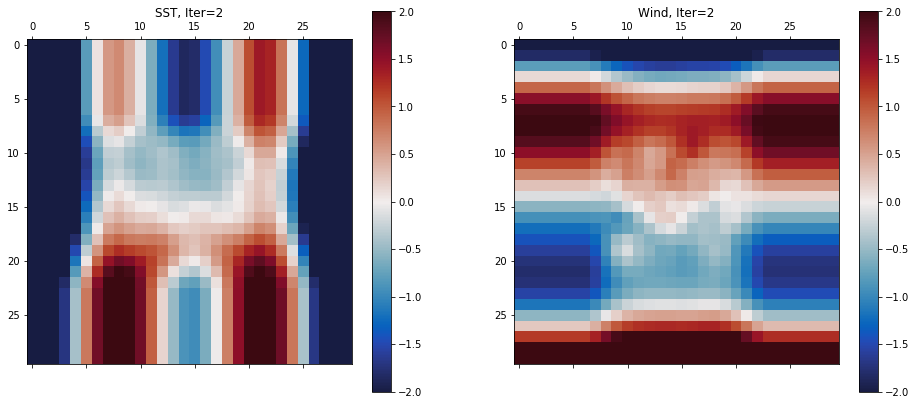

ARTS[94577016302144]:     3        1.20839       0.174219        1.03417       0.134735
ARTS[94577016302144]: --------------------------------------------------------------------------------
ARTS[94577016302144]: 
ARTS[94577016302144]: Total number of steps:            3
ARTS[94577016302144]: Final scaled cost function value: 1.20839
ARTS[94577016302144]: OEM computation converged.
ARTS[94577016302144]: 
ARTS[94577016302144]: Elapsed Time for Retrieval:                       314.025
ARTS[94577016302144]: Time in inversion_iterate Agenda (No Jacobian):   170.738
ARTS[94577016302144]: Time in inversion_iterate Agenda (With Jacobian): 141.299
ARTS[94577016302144]: 
ARTS[94577016302144]:                                       ----                                      
ARTS[94577016302144]: 

Completion time [s]: 456.5143585205078


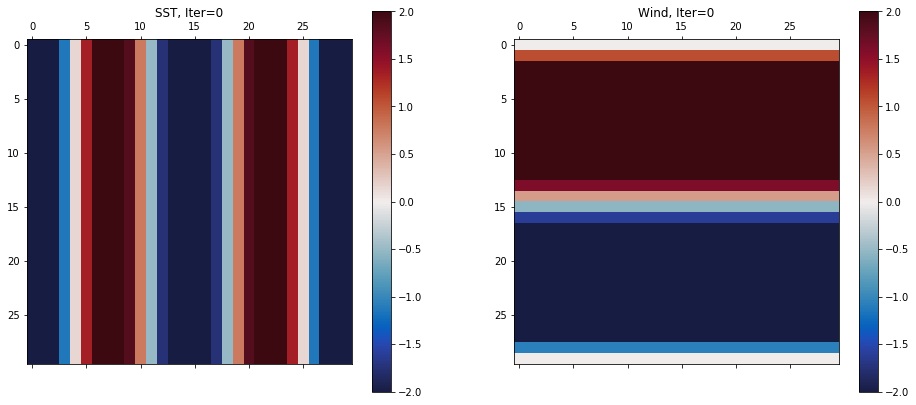

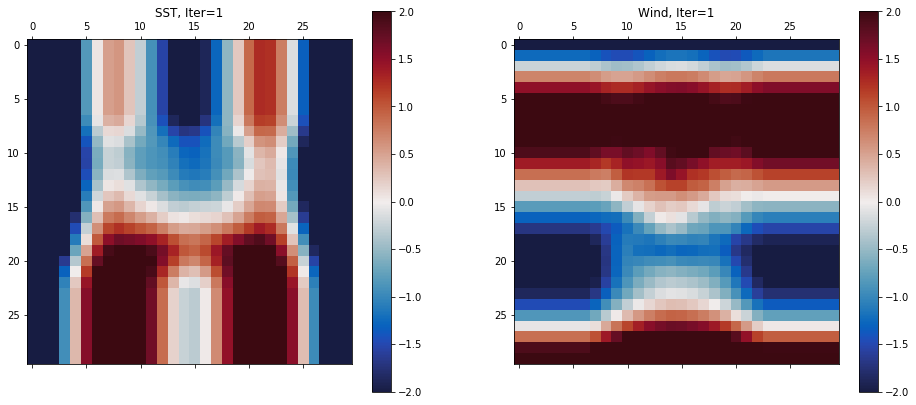

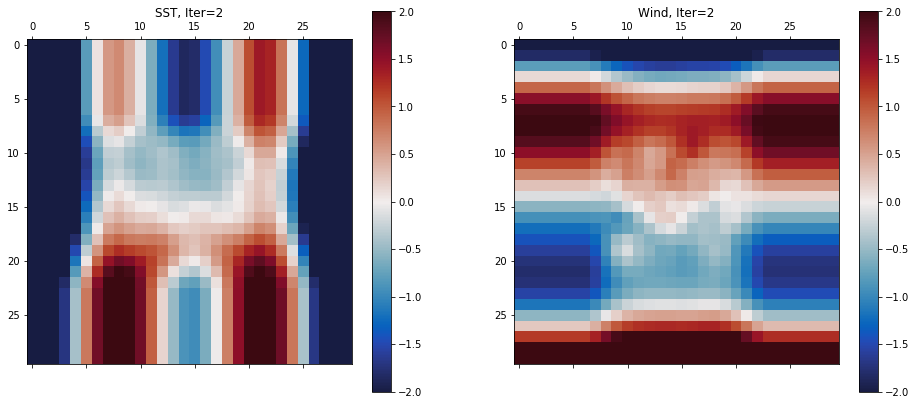

In [24]:
# Call OEM:

#  note: LM is better for non-linear problems and sfc retrieval should be very linear, so stick with GN/GN_CG
ws.OEM(method="gn",  # in one test LM took ~3x longer than GN!!
    max_iter=5,
    display_progress=1,
    max_start_cost=1e5,
    stop_dx=.4, # default is .01? -- this is to limit iterations, can dial back later for more exactness
    lm_ga_settings=np.array([10.0,2.0,3.0,10000000000.0,1.0,1.0])) # only applicable if method='lm'

ws.Print(ws.oem_errors, 0)  # print any errors to terminal

endt = time. time()
print('Completion time [s]:',endt - startt)

In [25]:
###### calculate averaging kernel (A matrix) and a posteriori 
# A matrix, S_o, S_s are all same size: [x,x] where x=npix*nscans*nretvar
ws.avkCalc()
Amat = ws.avk.value
print('Trace of A Matrix: ', np.trace(Amat))   #Trace(A) yields DOF for signal.
print('(out of possible points and vars:',np.diagonal(Amat).size)
print('  ...so DOF per retr grid point: ',np.trace(Amat)/np.diagonal(Amat).size)

ws.covmat_soCalc()
post = ws.covmat_so.value  # posterior error covariance matrix
ws.covmat_ssCalc()
smoov = ws.covmat_ss.value  # posterior error covariance matrix
# should be [x,x], providing uncertainties of each retrieved var, where x=npix*nscans*nretvar
 
### ARTS method: "Extracts error estimates for retr quantities from covariance
##  matrices for the error due to measurement noise covmat_so and the error 
##  due to limited resolution of the observation system" -- fwd model and smoothing errors.
ws.retrievalErrorsExtract( ws.covmat_so, ws.covmat_ss)  
#ws.retrievalErrorsExtract( ws.retrieval_eo, ws.retrieval_ss, ws.covmat_so, ws.covmat_ss) # returns first two 
print(np.shape(ws.retrieval_eo.value), np.shape(ws.retrieval_ss.value))
obs_err = np.copy(ws.retrieval_eo.value[:len_rgrid].reshape(r_lat.size,r_lon.size,order="F"))
smo_err = np.copy(ws.retrieval_ss.value[:len_rgrid].reshape(r_lat.size,r_lon.size,order="F"))
if nrvar>1:
    obs_err2 = np.copy(ws.retrieval_eo.value[len_rgrid:].reshape(r_lat.size,r_lon.size,order="F"))
    smo_err2 = np.copy(ws.retrieval_ss.value[len_rgrid:].reshape(r_lat.size,r_lon.size,order="F"))
    
vmi,vma = .1,.5
cm=cmo.thermal
#plt.pcolor(obs_err,vmin=vmi,vmax=vma,cmap=cm)
#plt.colorbar()
#plt.show()
#plt.pcolor(smo_err,vmin=vmi,vmax=vma,cmap=cm)
#plt.colorbar()
#plt.show()
#plt.pcolor(obs_err2,vmin=vmi,vmax=vma,cmap=cm)
#plt.colorbar()
#plt.show()
#plt.pcolor(smo_err2,vmin=vmi,vmax=vma,cmap=cm)
#plt.colorbar()
#plt.show()
#plt.pcolor(obs_err+smo_err,vmin=.2,vmax=.6,cmap=cm)
#plt.colorbar()
#plt.show()
#plt.pcolor(obs_err2+smo_err2,vmin=.2,vmax=.6,cmap=cm)
#plt.colorbar()
#plt.show()



Trace of A Matrix:  63.69341133027655
(out of possible points and vars: 3362
  ...so DOF per retr grid point:  0.018945095577119736
(3362,) (3362,)


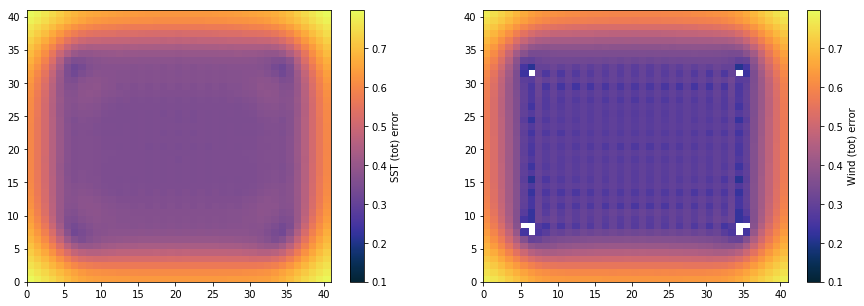

In [26]:
# save total errr plot
f, axs = plt.subplots(1, 2, figsize=[15,5])
ax_sst, ax_wsp = axs
errno = plt.Normalize(vmin=.1,vmax=np.max(obs_err+smo_err))
cm=cmo.thermal
ax_sst.pcolor(obs_err +smo_err,  norm=errno, cmap=cm)
ax_wsp.pcolor(obs_err2+smo_err2, norm=errno, cmap=cm)
sm = plt.cm.ScalarMappable(cmap=cm, norm=errno)
sm._A = []
cb = plt.colorbar(sm,ax=ax_sst,label='SST (tot) error')
sm2 = plt.cm.ScalarMappable(cmap=cm, norm=errno)
sm2._A = []
cb2 = plt.colorbar(sm2,ax=ax_wsp,label='Wind (tot) error')
f.savefig('')
if sv: plt.savefig('img2/tot-err_'+pv+'.png',bbox_inches='tight',dpi=350)
plt.show()

10 10
ratio of smoothing to obs error (sst):  2.055066244302343
ratio of smoothing to obs error (wsp):  1.6819583551791388


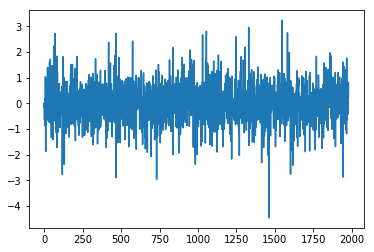

In [27]:
# from middle of retrieval grid, judge where the dominant error is coming from:
ed1,ed2 = int(.4/r_resa),int(.4/r_reso)
print(ed1,ed2)
print('ratio of smoothing to obs error (sst): ',np.mean( smo_err[ed2:-ed2,ed1:-ed1]/obs_err[ed2:-ed2,ed1:-ed1]))
print('ratio of smoothing to obs error (wsp): ',np.mean(smo_err2[ed2:-ed2,ed1:-ed1]/obs_err2[ed2:-ed2,ed1:-ed1]))

plt.plot(ws.y.value - ws.yf.value)  # quick dump of sim vs. 'obs' TBs in no [understandable] order

# Map variables back to scan/pixel arrays

In [28]:
# yf is y_fit whereas y itself is the measurement vector here, so obs-sim is y-yf:
ydif = np.copy( ws.y.value - ws.yf.value )
ysim = np.copy( ws.yf.value)

xretr = np.zeros_like(x_back)
xretr[0,:,:] = np.copy(ws.x.value[:len_rgrid].reshape(r_lat.size,r_lon.size,order="F"))
if nrvar>1:
    xretr[1,:,:] = np.copy(ws.x.value[len_rgrid:].reshape(r_lat.size,r_lon.size,order="F"))

xdif = xretr - x_back    # save retr vs prior/background on rgrid
xdif_a = xretr - xa       # save difference of apriori vs retrieved

geo = np.copy(ws.y_geo.value) #columns are altitude, lat, lon, zenith, azimuth of measurement geoposition
# y vector should be of size [nf*2 (stokes dim 2) ] * npix*nscans  

# vars coming out of yCalc should be in order, nch then npix then nscans, i.e.:
## with nch=6 first 6 values are from pix1,sc1 then next 6 are pix2,sc1 and so on -- be careful!
# can compare geo[:,3] (az) to EIA from L1R (later), just 180-az to get EIA


# convert vectors back to scan/pixel matrices:
sim_tb = np.zeros([nscans,npix,nf*2])
dif_tb = np.zeros([nscans,npix,nf*2]) 
arts_pos = np.zeros([nscans,npix,4]) 
#print(nf*2,npix,nscans)

for c in range(nf*2):
    sim_tb[:,:,c] = ysim[c::nf*2].reshape(nscans,npix)
    dif_tb[:,:,c] = ydif[c::nf*2].reshape(nscans,npix)
    for bb in range(4):
        arts_pos[:,:,bb] = geo[c::nf*2,bb+1].reshape(nscans,npix)  # lat,lon,zenith,azimuth
        ## arts obs points -- can differ slightly from prescribed, defined where max response is registered!

(1681, 41, 41)
A1 sum:  0.9975580593448079
A2 sum:  0.9998335210747471


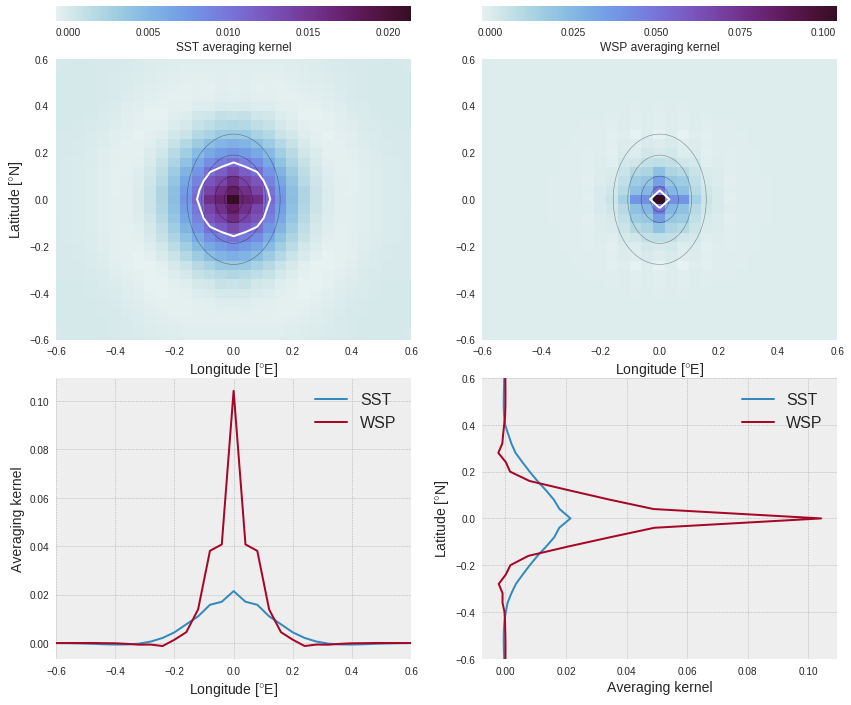

In [41]:
# just diagonal elements from A matrix, back to rlat/rlon grid
#Amat_d_re = np.zeros_like(x_back) 
#Amat_d_re[0,:,:] = np.copy( np.diagonal(Amat)[:len_rgrid].reshape(r_lat.size,r_lon.size,order="F"))
#if nrvar>1:
#    Amat_d_re[1,:,:] = np.copy( np.diagonal(Amat)[len_rgrid:].reshape(r_lat.size,r_lon.size,order="F"))
    
# want to fill [npts,rlat,rlon] grid with A values for each retrieval var

Amat_chosen1 = np.copy( Amat[:len_rgrid, :len_rgrid].reshape(len_rgrid,r_lat.size,r_lon.size,order="F") )
print(np.shape(Amat_chosen1))
# first quadrant of Amat (SST)
if nrvar>1:
    ## 2nd quadrant of Amat (wind)
    Amat_chosen2 = np.copy( Amat[len_rgrid:, len_rgrid:].reshape(len_rgrid,r_lat.size,r_lon.size,order="F") )

# pick a rgrid point in middle of grid and extract Amat:
 # [if even number of points in rlon grid, need this to pick point near center of grid]
rchos= 0 
if np.mod(r_lon.size,2)==0:
    rchose = int(r_lat.size/2)
ehn = int(len_rgrid/2.0 +rchos)
#print(ehn, rchos)
print('A1 sum: ',np.sum(Amat_chosen1[ehn,:,:]))
print('A2 sum: ',np.sum(Amat_chosen2[ehn,:,:]))

# try gridspec?
import matplotlib.gridspec as gridspec
f1 = plt.figure(figsize=[14,12])
gs = gridspec.GridSpec(3, 2, height_ratios = [0.05, 1.0, 1.0])#, figsize=[14,14])
ax_cb1 = plt.subplot(gs[0, 0])
ax_cb2 = plt.subplot(gs[0, 1])
# Plot first image and draw colorbar in axes above.
ax_im1 = plt.subplot(gs[1, 0])
ax_im2 = plt.subplot(gs[1, 1])
ax_p1  = plt.subplot(gs[2, 0])
ax_p2  = plt.subplot(gs[2, 1])

plt.style.use('bmh')
fs = 16
# to fix the lat/lon, since pcolor uses grid corners not midpoints:
rjp = rj-r_reso/2
rip = ri-r_resa/2
pangl = -np.mean(arts_pos[:,:,3])  # just taking the mean angular orientation of FOVs from whole scene
awidths = widths * 360.0/40075. #/ np.abs(np.cos(np.mean(ri)*np.pi/180.)) # scale widths by cos(lat)
aheights= heights* 360.0/40075. 
#aheights /= np.abs(np.cos(np.mean(ri)*np.pi/180.)) # scale heights by cos(lat)
#awidths /= np.abs(np.cos(np.mean(ri)*np.pi/180.))  # scale widths  by cos(lat)
achans = [0,4,6,8]

cmavk = cmo.dense
av1mx = np.max(Amat_chosen1[ehn,:,:])
avoff = 0.6  # degrees width on either side to be shown in figures
thenorma1 = plt.Normalize(vmin=np.min(Amat_chosen1[ehn,:,:]),vmax=av1mx)
im1 = ax_im1.pcolormesh(rjp,rip,Amat_chosen1[ehn,:,:], cmap=cmavk, norm=thenorma1)
ax_im1.contour(rj,ri, Amat_chosen1[ehn,:,:], levels=[av1mx/2,av1mx], colors='white')
cb1 = plt.colorbar(im1, cax=ax_cb1, label='SST averaging kernel', orientation='horizontal')
cb1.locator = ticker.MaxNLocator(nbins=5) 
cb1.update_ticks()
max_ind = np.unravel_index(np.argmax(Amat_chosen1[ehn,:,:], axis=None), rj.shape)
ella = [Ellipse(xy=[rj[max_ind],ri[max_ind]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
            angle=pangl, linewidth=0.6, alpha=0.4, fill=False, color='black') for k in achans]
ax_im1.set_xlim([lon0-avoff, lon0+avoff]) #(if) shared axes, applies to both
ax_im1.set_ylim([lat0-avoff, lat0+avoff]) 
ax_im1.set_ylabel('Latitude [$\degree$N]', fontsize=fs-2)
ax_im1.set_xlabel('Longitude [$\degree$E]', fontsize=fs-2)
ax_im2.set_xlabel('Longitude [$\degree$E]', fontsize=fs-2)
for el in ella:
    ax_im1.add_artist(el)
if nrvar>1:
    av2mx = np.max(Amat_chosen2[ehn,:,:])
    thenorma2 = plt.Normalize(vmin=np.min(Amat_chosen2[ehn,:,:]),vmax=av2mx)
    max_ind = np.unravel_index(np.argmax(Amat_chosen2[ehn,:,:], axis=None), rj.shape)
    ella2 = [Ellipse(xy=[rj[max_ind],ri[max_ind]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
            angle=pangl, linewidth=0.6, alpha=0.4, fill=False, color='black') for k in achans]
    im2 = ax_im2.pcolormesh(rjp,rip,Amat_chosen2[ehn,:,:], cmap=cmavk, norm=thenorma2)
    ax_im2.contour(rj,ri, Amat_chosen2[ehn,:,:], levels=[av2mx/2,av2mx], colors='white')
    cb2 = plt.colorbar(im2, cax=ax_cb2, label='WSP averaging kernel', orientation='horizontal')
    cb2.locator = ticker.MaxNLocator(nbins=5) 
    cb2.update_ticks()
    for el in ella2:
        ax_im2.add_artist(el)
    ax_im2.set_xlim([lon0-avoff, lon0+avoff]) #(if) shared axes, applies to both
    ax_im2.set_ylim([lat0-avoff, lat0+avoff]) 
        
ax_p1.plot(rj[int(r_lat.size/2),:], Amat_chosen1[ehn,int(r_lat.size/2),:], label='SST')
ax_p1.plot(rj[int(r_lat.size/2),:], Amat_chosen2[ehn,int(r_lat.size/2),:], label='WSP')
ax_p1.set_ylabel('Averaging kernel', fontsize=fs-2)
ax_p1.set_xlabel('Longitude [$\degree$E]', fontsize=fs-2)
ax_p1.set_xlim(lon0-avoff, lon0+avoff)
ax_p1.legend(fontsize=fs)
ax_p2.plot(Amat_chosen1[ehn,:,int(r_lon.size/2)],ri[:,int(r_lon.size/2)],  label='SST') #10:38
ax_p2.plot(Amat_chosen2[ehn,:,int(r_lon.size/2)],ri[:,int(r_lon.size/2)],  label='WSP')
ax_p2.set_ylim(lat0-avoff, lat0+avoff)
ax_p2.set_ylabel('Latitude [$\degree$N]', fontsize=fs-2)
ax_p2.set_xlabel('Averaging kernel', fontsize=fs-2)
ax_p2.legend(fontsize=fs)
        
apvr = 'v2'
plt.savefig('img2/avgk_4pan_overlaid_'+pv+'_'+apvr+'.png', bbox_inches='tight', dpi=300)


In [30]:
# take one row of A matrix from each retr variable block:
dexes = np.random.choice(range(len_rgrid), 6)
for c in dexes:
    print('sst @',c,np.sum(Amat[:len_rgrid, :len_rgrid][c,:]))
    print('wsp @',c,np.sum(Amat[len_rgrid:, len_rgrid:][c,:]))


sst @ 58 0.9558895674089475
wsp @ 58 0.9623835014350587
sst @ 1353 0.8979814821264224
wsp @ 1353 0.9076912477689345
sst @ 816 0.9659059966654909
wsp @ 816 0.9803691927472717
sst @ 1449 0.9989066704110919
wsp @ 1449 0.9986176157406963
sst @ 1032 0.9995992688016696
wsp @ 1032 0.9993748334098737
sst @ 362 0.9832951220986924
wsp @ 362 0.9952355751539143


In [31]:
## yf is y_fit whereas y itself is the measurement vector here, so obs-sim is y-yf:
#ydif = np.copy( ws.y.value - ws.yf.value )
#ysim = np.copy( ws.yf.value)
#
#xretr = np.zeros_like(x_truth)
#xretr[0,:,:] = np.copy(ws.x.value[:len_rgrid].reshape(r_lat.size,r_lon.size,order="F"))
#if nrvar>1:
#    xretr[1,:,:] = np.copy(ws.x.value[len_rgrid:].reshape(r_lat.size,r_lon.size,order="F"))
#
#xdif = xretr - x_truth    # save retr vs truth on rgrid
#xdif_a = xretr - xa       # save difference of apriori vs retrieved
#
#geo = np.copy(ws.y_geo.value) #columns are altitude, lat, lon, zenith, azimuth of measurement geoposition
#print(np.shape(ws.y.value))
## y vector should be of size [nf*2 (stokes dim 2) ] * npix*nscans  
#
## vars coming out of yCalc should be in order, nch then npix then nscans, i.e.:
### with nch=6 first 6 values are from pix1,sc1 then next 6 are pix2,sc1 and so on -- be careful!
## can compare geo[:,3] (az) to EIA from L1R (later), just 180-az to get EIA
#
#
## convert vectors back to scan/pixel matrices:
#sim_tb = np.zeros([nscans,npix,nf*2])
#dif_tb = np.zeros([nscans,npix,nf*2]) 
#arts_pos = np.zeros([nscans,npix,4]) 
#print(nf*2,npix,nscans)
#
#for c in range(nf*2):
#    sim_tb[:,:,c] = ysim[c::nf*2].reshape(nscans,npix)
#    dif_tb[:,:,c] = ydif[c::nf*2].reshape(nscans,npix)
#    for bb in range(4):
#        arts_pos[:,:,bb] = geo[c::nf*2,bb+1].reshape(nscans,npix) 
#        ## arts obs points -- can differ slightly from prescribed, defined where max response is registered!
#        
#    
#print(np.shape(dif_tb))
#plt.imshow(dif_tb[:,:,0]) # 6V obs-sim
#plt.colorbar()
#plt.show()
#plt.imshow(dif_tb[:,:,nf*2-1]) # last _H obs-sim
#plt.colorbar()
#plt.show()
#

# Plot results

In [43]:

projj = ccrs.PlateCarree()
inn =  .4
reg = [np.min(la_grid)+inn, np.max(la_grid)-inn,
           np.min(lo_grid)+inn, np.max(lo_grid)-inn]
rreg = [np.min(r_lat), np.max(r_lat),
           np.min(r_lon), np.max(r_lon)]
reg = np.round(reg,1)
rreg = np.round(rreg,1)
print('region: ',reg)
print('r region: ',rreg)

region:  [-1.1  1.1 -1.1  1.1]
r region:  [-0.8  0.8 -0.8  0.8]


In [33]:
#
#ks = [0,5]#,nf*2-1] # channel indices to plot
#
#for k in ks:
#    # provide x,y coords, width, height, angle of each FOV-- make an ellipse
#    ells = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[int(k/2)], height=heights[int(k/2)], 
#                    angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False) 
#            for i in range(nscans) for j in range(npix)]# for k in [0]] #range(nf*2)]
#
#    fig = plt.figure(figsize=[18,10])
#    ax = plt.subplot(111, projection=projj )
#
#    ax.set_xlim(left=reg[2], right=reg[3])
#    ax.set_ylim(bottom=reg[0], top=reg[1])
#    nx,ny = 5,5
#    ax.set_xticks( np.linspace(reg[2],reg[3], nx) )
#    ax.set_yticks( np.linspace(reg[0],reg[1], ny) )
#
#    #sdif = np.max(np.abs(tmean-s_data[0,:,:])) # set colorbar limits by largest abs deviation from tmean?
#    thenorm1=plt.Normalize(vmin = np.min(s_data[0,:,:])-1, vmax = np.max(s_data[0,:,:])+1)
#    ceem1=cmo.dense
#    #bb= ax.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
#    bb= ax.contourf(ws.lon_grid,ws.lat_grid,s_data[0,:,:], 10, norm=thenorm1, # so SST
#                 transform=projj, cmap=ceem1)
#
#    for e in ells[:]: 
#        ax.add_artist(e)
#
#    vmin, vmax = -np.max(np.abs(dif_tb[:,:,k])), np.max(np.abs(dif_tb[:,:,k]))
#    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
#    ceem = cmo.balance #thermal
#    ax.scatter( arts_pos[:,:,1], arts_pos[:,:,0], s=100.0, c=dif_tb[:,:,k], marker='o', \
#                transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
#    sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
#    sm._A = []
#    cb = plt.colorbar(sm,ax=ax)
#    cb.set_label(ch_str[k]+' TB [K] (obs-sim)')
#    sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
#    sm1._A = []
#    cb1 = plt.colorbar(sm1,ax=ax)
#    cb1.set_label('SST [K]')
#
#    if sv: plt.savefig('img2/retr-y_syn_'+ch_str[k]+'_'+pv+'.png',bbox_inches='tight',dpi=350)
#    plt.show()
#
#
#

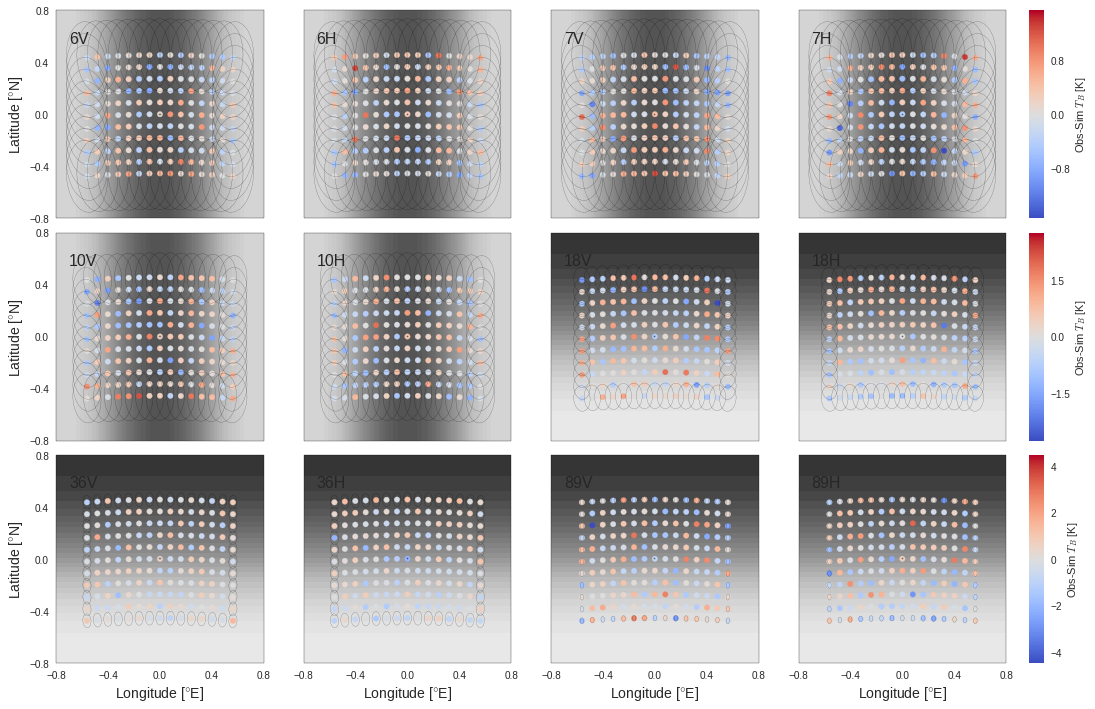

In [63]:
plt.style.use('seaborn')

ydif_figsize = [18,12]
f2 = plt.figure(figsize=ydif_figsize)

#f, ax_tb = plt.subplots(nrows=int(np.ceil(nf/2)), ncols=4, figsize=ydif_figsize,
#                        subplot_kw=dict(projection=projj), sharex=True, sharey=True)
topl = 0
nx,ny = 5,5
ceem1 = 'Greys' #cmo.algae
ceem  = 'coolwarm' #cmo.balance #thermal
kd = np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]]) # lazy coding, row indexing
gs = gridspec.GridSpec(3, 5, width_ratios = [1,1,1,1,.06])

for k in range(nf*2):
    kx, ky = int(np.floor(k/4)), np.mod(k,4)
    # provide x,y coords, width, height, angle of each FOV-- make an ellipse
    ell_lo = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
              for i in [0,nscans-1] for j in range(npix)[1:-1]]
    ell_lo += [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
               for i in range(nscans) for j in [0,npix-1] ] 

    ax_tb = plt.subplot(gs[kx,ky], projection=projj)
    if k > 5: topl=1   # so plot contours of SST for first 6 panels, WSP for last 6
    thenorm1=plt.Normalize(vmin = np.min(xretr[topl,:,:])-3, vmax = np.max(xretr[topl,:,:])+3)
    #bb= ax.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
    bb= ax_tb.contourf(ws.lon_grid,ws.lat_grid,s_data[topl,:,:], 30, norm=thenorm1,
                 transform=ccrs.PlateCarree(), cmap=ceem1)
    ax_tb.set_extent([rreg[2],rreg[3],rreg[0],rreg[1]])
    ax_tb.coastlines(resolution='10m')

    for e in ell_lo[:]: 
        ax_tb.add_artist(e)

    vmin, vmax = -np.max(np.abs(dif_tb[:,:,kd[kx,:]])), np.max(np.abs(dif_tb[:,:,kd[kx,:]]))
    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
    sct = ax_tb.scatter( arts_pos[:,:,1], arts_pos[:,:,0], s=30.0, c=dif_tb[:,:,k], marker='o', \
                transform=ccrs.PlateCarree(), alpha=1.0, cmap=ceem, norm=thenorm);
    ax_tb.text(rreg[2]+.10, rreg[1]-.25, ch_str[k], fontsize=fs+2)
        
    if ky==0:
        ax_tb.set_yticks( np.linspace(rreg[0],rreg[1], ny) )
        ax_tb.set_ylabel( 'Latitude [$\degree$N]',fontsize=fs)
    if kx==2:
        ax_tb.set_xticks( np.linspace(rreg[2],rreg[3], nx) )
        ax_tb.set_xlabel( 'Longitude [$\degree$E]',fontsize=fs)
    if ky==3: # end of row, create colorbar for row:
        cb1 = plt.colorbar(sct, cax=plt.subplot(gs[kx,4]), label='Obs-Sim $T_B$ [K]', shrink=.8,
           norm=plt.Normalize(vmin=-np.max(np.abs(dif_tb[:,:,kd[kx,:]])), vmax=np.max(np.abs(dif_tb[:,:,kd[kx,:]]))) )
        cb1.locator = ticker.MaxNLocator(nbins=5) 
        cb1.update_ticks()
        
plt.subplots_adjust( wspace=.03,hspace=.07) #, right=.9)
if sv: plt.savefig('img2/ydif_'+pv+'.png',bbox_inches='tight',dpi=220)
plt.show()


In [35]:
## older subplot version of tb plot, with colorbars for each panel, instead of using gridspec and 3 colorbars total
#plt.style.use('seaborn')
#
#ydif_figsize = [18,12]
##if scene=='aus': ydif_figsize = [18,8]
#f, ax_tb = plt.subplots(nrows=int(np.ceil(nf/2)), ncols=4, figsize=ydif_figsize,
#                        subplot_kw=dict(projection=projj), sharex=True, sharey=True)
#topl = 0
#nx,ny = 5,5
#ceem1 = cmo.dense
#ceem  = cmo.balance #thermal
#kd = np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]]) # lazy coding, row indexing
##gs = gridspec.GridSpec(3, 5, width_ratios = [1,1,1,1,.2])
#
#for k in range(nf*2):
#    kx, ky = int(np.floor(k/4)), np.mod(k,4)
#    # provide x,y coords, width, height, angle of each FOV-- make an ellipse
#    ell_lo = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
#            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
#              for i in [0,nscans-1] for j in range(npix)]
#    ell_lo += [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
#            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
#               for i in range(nscans) for j in [0,npix-1] ] 
#
#    if k > 5: topl=1   # so plot contours of SST for first 6 panels, WSP for last 6
#    #thenorm1=plt.Normalize(vmin = np.min(s_data[topl,:,:])-1, vmax = np.max(s_data[topl,:,:])+1)
#    thenorm1=plt.Normalize(vmin = np.min(xretr[topl,:,:])-3, vmax = np.max(xretr[topl,:,:])+3)
#    #bb= ax.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
#    bb= ax_tb[kx,ky].contourf(ws.lon_grid,ws.lat_grid,s_data[topl,:,:], 30, norm=thenorm1, # so SST
#                 transform=ccrs.PlateCarree(), cmap=ceem1)
#    ax_tb[kx,ky].set_extent([rreg[2],rreg[3],rreg[0],rreg[1]])
#    ax_tb[kx,ky].coastlines(resolution='10m')
#
#    for e in ell_lo[:]: 
#        ax_tb[kx,ky].add_artist(e)
#
#    vmin, vmax = -np.max(np.abs(dif_tb[:,:,kd[kx,:]])), np.max(np.abs(dif_tb[:,:,kd[kx,:]]))
#    #vmin, vmax = -np.max(np.abs(dif_tb[:,:,k])), np.max(np.abs(dif_tb[:,:,k]))
#    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
#    ax_tb[kx,ky].scatter( arts_pos[:,:,1], arts_pos[:,:,0], s=15.0, c=dif_tb[:,:,k], marker='o', \
#                transform=ccrs.PlateCarree(), alpha=1.0, cmap=ceem, norm=thenorm);
#    sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
#    sm._A = []
#    cb = plt.colorbar(sm, ax=ax_tb[kx,ky], shrink=.8)
#    cb.locator = ticker.MaxNLocator(nbins=5) # new 2 lines
#    cb.update_ticks()
#    #cb.set_label(ch_str[k]+' $T_B$ [K] (obs-sim)')
#    ax_tb[kx,ky].text(rreg[2]+.10, rreg[1]-.25, ch_str[k], fontsize=fs+2)
#        
#    #ax_tb[kx,ky].set_title(ch_str[k])
#    if ky==0:
#        ax_tb[kx,ky].set_yticks( np.linspace(rreg[0],rreg[1], ny) )
#        ax_tb[kx,ky].set_ylabel( 'Latitude [$\degree$N]',fontsize=fs)
#    if kx==2:
#        ax_tb[kx,ky].set_xticks( np.linspace(rreg[2],rreg[3], nx) )
#        ax_tb[kx,ky].set_xlabel( 'Longitude [$\degree$E]',fontsize=fs)
#
#plt.subplots_adjust( wspace=.04,hspace=.07, right=.9)
#if sv: plt.savefig('img2/ydif_all_'+pv+'.png',bbox_inches='tight',dpi=220)
##if sv: plt.savefig('imgr/retr'+str(topl)+'-y_syn_'+ch_str[k]+'_'+pv+'.png',bbox_inches='tight',dpi=300)
#plt.show()
#

In [36]:
#
#figx = plt.figure(figsize=[18,8])
#gs = gridspec.GridSpec(1,3*nrvar, width_ratios=[.2,.2,1,1,.2,.2]) #height_ratios = [1,.06,.06])
## and for the state vector, retrieved vs. a priori laid over background (truth):
#pvar = xdif # choose what to  plot here
## define as subplots, put both fields on same figure? maybe side by side with cbars below?
#ceem = cmo.balance #thermal
#
#for rv in range(nrvar): 
#    if rv==0: tit='SST [K]'
#    if rv==1: tit='Wind speed [$m s^{-1}$]'
#    ax2 = plt.subplot(gs[0,2+rv], projection=projj )
#
#    ax2.set_xlim(left=reg[2], right=reg[3])
#    ax2.set_ylim(bottom=reg[0], top=reg[1])
#    ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
#    ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )
#    if rv==0: ax2.set_ylabel( 'Latitude [$^o N$]' )
#    ax2.set_xlabel( 'Longitude [$^o E$]' )
#
#    thenorm1=plt.Normalize(vmin = np.min(s_data[rv,:,:])-.5, vmax = np.max(s_data[rv,:,:])+.5)
#    #bb= ax2.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, 
#    bb= ax2.contourf(ws.lon_grid,ws.lat_grid,s_data[rv,:,:], 10, norm=thenorm1, 
#                 transform=projj, cmap=ceem1)
#
#    #for e in ells[:]: 
#    #    ax2.add_artist(e)
#
#    vmin, vmax = -np.max(np.abs(pvar[rv,:,:])), np.max(np.abs(pvar[rv,:,:]))
#    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
#    # ri,rj defined earlier via meshgrid, i.e. retrieval lon and lat grids respectively
#    sct2 = ax2.scatter( rj, ri, s=60.0, c=pvar[rv,:,:], marker='o', \
#                transform=projj, alpha=0.8, cmap=ceem, norm=thenorm)
#    
#    dex = 0
#    if rv==1: dex=4
#    cb1 = plt.colorbar(bb,   cax=plt.subplot(gs[0,dex]), label=tit, shrink=.7,
#           norm=thenorm1, orientation='vertical')
#    cb2 = plt.colorbar(sct2, cax=plt.subplot(gs[0,dex+1]), label=tit+' (retr - truth)',
#           norm=thenorm, orientation='vertical')
#    
#plt.subplots_adjust(hspace=.36, wspace=.2)
#if sv: figx.savefig('img2/retr-x_syn_2pan_'+pv+'.png',bbox_inches='tight',dpi=250)

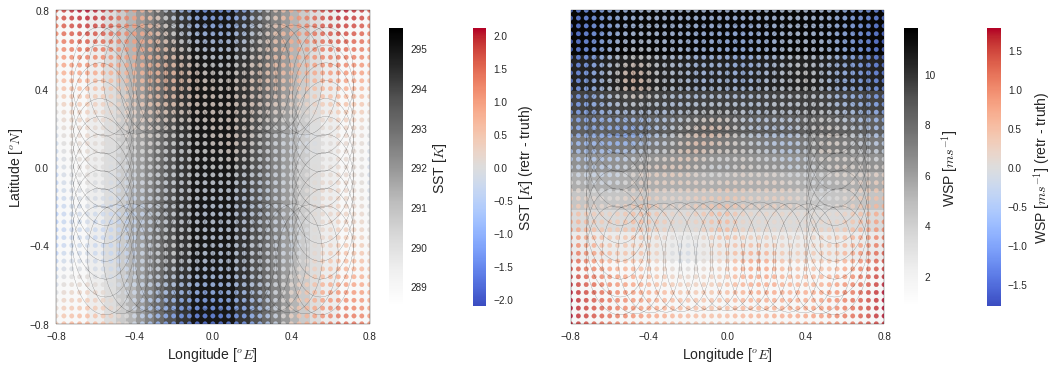

In [62]:

f2,axes2 = plt.subplots(1,2, figsize=[18,6],
                        subplot_kw=dict(projection=projj), sharex=True, sharey=True)
# and for the state vector, retrieved vs. a priori laid over background (truth):
fs = 14
pvar = xdif # choose what to  plot here
# define as subplots, put both fields on same figure? maybe side by side with cbars below?
ceem = 'coolwarm' #cmo.balance
ceem1 = 'Greys' #cmo.algae

for rv in range(nrvar): 
    if rv==0: tit='SST [$K$]'
    if rv==1: tit='WSP [$m s^{-1}$]'

    ax2 = axes2[rv]
    ax2.set_xlim(left=rreg[2], right=rreg[3])
    ax2.set_ylim(bottom=rreg[0], top=rreg[1])
    ax2.set_xticks( np.linspace(rreg[2],rreg[3], nx) )
    ax2.set_yticks( np.linspace(rreg[0],rreg[1], ny) )
    if rv==0: ax2.set_ylabel( 'Latitude [$^o N$]', fontsize=fs)
    ax2.set_xlabel( 'Longitude [$^o E$]', fontsize=fs)

    thenorm1=plt.Normalize(vmin = np.min(s_data[rv,:,:])-.5, vmax = np.max(s_data[rv,:,:])+.5)
    #bb= ax2.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, 
    bb= ax2.contourf(ws.lon_grid,ws.lat_grid,s_data[rv,:,:], 10, norm=thenorm1, 
                 transform=projj, cmap=ceem1)

    ell_lo = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[0], height=aheights[0], 
            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
              for i in [0,nscans-1] for j in range(npix)[1:-1]]
    ell_lo += [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[0], height=aheights[0], 
            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
               for i in range(nscans) for j in [0,npix-1] ] 
    for e in ell_lo[:]: 
        ax2.add_artist(e)

    vmin, vmax = -np.max(np.abs(pvar[rv,:,:])), np.max(np.abs(pvar[rv,:,:]))
    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
    # ri,rj defined earlier via meshgrid, i.e. retrieval lon and lat grids respectively
    ax2.scatter( rj, ri, s=20.0, c=pvar[rv,:,:], marker='o', \
                transform=projj, alpha=0.8, cmap=ceem, norm=thenorm)
    sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
    sm._A = []
    cb  = plt.colorbar(sm, ax=ax2, shrink=.85)
    cb.set_label(tit+' (retr - truth)',fontsize=fs)
    sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
    sm1._A = []
    cb1 = plt.colorbar(sm1, ax=ax2, shrink=.85)
    cb1.set_label(tit, fontsize=fs)
    #ax2.text(reg[2]+.10, reg[1]-.2, tit, fontsize=fs)

plt.subplots_adjust(wspace=.05)
if sv: plt.savefig('img2/retr-x_syn_rv'+str(rv)+'_'+pv+'.png',bbox_inches='tight',dpi=300)

In [ ]:
## SANITY CHECK: plot background (synthetic defined) state vs. x_back on retrieval grid. 
##    should be simply interpolated values!
#
## and for the state vector, retrieved vs. a priori laid over background (truth):
#projj = ccrs.PlateCarree()
#inn =  0.6
#nx,ny = 5,5
#for rv in range(nrvar): 
#    if rv==0: tit='SST [K]'
#    if rv==1: tit='Wind speed [$m s^{-1}$]'
#    fig2 = plt.figure(figsize=[18,10])
#    ax2 = plt.subplot(111, projection=projj )
#
#    ax2.set_xlim(left=reg[2], right=reg[3])
#    ax2.set_ylim(bottom=reg[0], top=reg[1])
#    ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
#    ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )
#    ax2.set_ylabel( 'Latitude [$^o N$]' )
#    ax2.set_xlabel( 'Longitude [$^o E$]' )
#
#    thenorm1=plt.Normalize(vmin = np.min(s_data[rv,:,:])-1, vmax = np.max(s_data[rv,:,:])+1)
#    #bb= ax2.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, 
#    #bb= ax2.contourf(ws.lon_grid,ws.lat_grid,s_data[rv,:,:], 10, norm=thenorm1, 
#    print(np.shape(gi),np.shape(s_data))
#    bb= ax2.scatter(gj, gi, s=200, c=s_data[rv,:,:], norm=thenorm1, 
#                 transform=projj, cmap=cmo.dense)
#
#    #for e in ells[:]: 
#    #    ax2.add_artist(e)
#
#    #xdif2 = xretr - x_back
#    #vmin, vmax = -np.max(np.abs(xdif2[rv,:,:])), np.max(np.abs(xdif2[rv,:,:]))
#    #thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
#    ceem = cmo.dense
#    # ri,rj defined earlier via meshgrid, i.e. retrieval lon and lat grids respectively
#    #ax2.scatter( rj, ri, s=150.0, c=x_back[rv,:,:], marker='o', \
#    ax2.scatter( rj, ri, s=80.0, c=xretr[rv,:,:], marker='o', \
#                transform=projj, alpha=0.8, cmap=ceem, norm=thenorm1);
#    #sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm1)
#    #sm._A = []
#    #cb = plt.colorbar(sm,ax=ax2)
#    #cb.set_label(tit+' (retr - prior)')
#    sm1 = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm1)
#    sm1._A = []
#    cb1 = plt.colorbar(sm1,ax=ax2)
#    cb1.set_label(tit)
#    ax2.set_title("Retr grid over background (truth)")
#
#    #if sv: plt.savefig('img2/retr-x_syn_rv'+str(rv)+'_'+pv+'.png',bbox_inches='tight',dpi=350)
#    plt.show()

In [ ]:
## and for the DOF, take elements from A matrix diagonal:
#fig3 = plt.figure(figsize=[15,10])
#ax3 = plt.subplot(111, projection=projj )
#
#ax3.set_xlim(left=reg[2], right=reg[3])
#ax3.set_ylim(bottom=reg[0], top=reg[1])
#ax3.set_xticks( np.linspace(reg[2],reg[3], nx) )
#ax3.set_yticks( np.linspace(reg[0],reg[1], ny) )
#
#bb= ax3.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
#             transform=projj, cmap=ceem1)
#
##for e in ells[:]: 
##    ax3.add_artist(e)
#    
#vmin, vmax = 0, 1 #-np.max(np.abs(xdif[:,:])), np.max(np.abs(xdif[:,:]))
#thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
#ceem = cmo.solar
## ri,rj defined earlier via meshgrid
#ax3.scatter( ri, rj, s=200.0, c=Amat_re[0,:,:], marker='o',    # pick which Amat vars?
#            transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
#sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
#sm._A = []
#cb = plt.colorbar(sm,ax=ax3)
#cb.set_label('DOFS')
#sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
#sm1._A = []
#cb1 = plt.colorbar(sm1,ax=ax3)
#cb1.set_label('SST [K]')
#
##plt.savefig('img2/retr-A_syn_'+pv+'.png',bbox_inches='tight',dpi=350)
#plt.show()